In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc

from catboost import CatBoostClassifier, Pool

#  Loading Data

In [2]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [3]:
feat = pd.read_csv('features.csv', sep='\t', header=0).drop('Unnamed: 0', axis=1)

# Vars

In [4]:
USER_COL = 'id'
SERVICE_COL = 'vas_id'
ACTUAL_COL = 'bought_service'

In [5]:
common_users = train[USER_COL].unique()
RANDOM_STATE = 21
train_users = train.id.tolist()
test_users = test.id.tolist()

# Categorics

In [6]:
X_1 = train.merge(feat, on='id', how='left').drop(['buy_time_x', 'buy_time_y'], axis=1)

In [7]:
n_unique_v_of_feature = X_1.nunique()

In [8]:
f_const = set(n_unique_v_of_feature[n_unique_v_of_feature == 1].index.tolist())

In [49]:
f_numeric = set(n_unique_v_of_feature[n_unique_v_of_feature >= 10].index.tolist())
f_numeric = [i for i in f_numeric if i not in f_const]
f_numeric.remove('id')

In [50]:
f_cat = set(n_unique_v_of_feature[n_unique_v_of_feature < 10].index.tolist())
f_cat = [i for i in f_cat if i not in f_const and f_cat]
f_cat.remove('target')

In [65]:
'203' in f_cat

False

In [51]:
f_const

{'139', '203', '75', '81', '85'}

# Preprocess

In [60]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [67]:
cat_pipe = Pipeline([
    ('selector', ColumnSelector(f_cat)),
    ('imputer', SimpleImputer(strategy="most_frequent")), 
])

num_pipe = Pipeline([
    ('selector', ColumnSelector(f_numeric)),
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

In [77]:
X_1 = X_1.drop(f_const, axis=1)

KeyError: "['203' '81' '75' '85' '139'] not found in axis"

In [78]:
y = X_1['target']
X = X_1.drop(['id', 'target'], axis=1)

In [70]:
pipe = Pipeline([('pre', preprocessor),
                ('model', CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1, ))
                ])

# Train - Test Split

In [79]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.92757
1.0    0.07243
Name: target, dtype: float64

Test
0.0    0.927972
1.0    0.072028
Name: target, dtype: float64


# Predict

In [80]:
pipe.fit(X_train, y_train)

0:	learn: 0.5501661	total: 673ms	remaining: 11m 12s
1:	learn: 0.4480544	total: 1.26s	remaining: 10m 30s
2:	learn: 0.3798504	total: 1.82s	remaining: 10m 5s
3:	learn: 0.3382760	total: 2.48s	remaining: 10m 17s
4:	learn: 0.2975265	total: 3.1s	remaining: 10m 16s
5:	learn: 0.2749353	total: 3.66s	remaining: 10m 6s
6:	learn: 0.2527218	total: 4.17s	remaining: 9m 51s
7:	learn: 0.2374810	total: 4.67s	remaining: 9m 38s
8:	learn: 0.2283654	total: 5.26s	remaining: 9m 39s
9:	learn: 0.2195215	total: 5.89s	remaining: 9m 42s
10:	learn: 0.2156447	total: 6.52s	remaining: 9m 46s
11:	learn: 0.2083115	total: 7.09s	remaining: 9m 43s
12:	learn: 0.2030572	total: 7.66s	remaining: 9m 41s
13:	learn: 0.2005537	total: 8.25s	remaining: 9m 41s
14:	learn: 0.1969687	total: 8.8s	remaining: 9m 37s
15:	learn: 0.1942459	total: 9.28s	remaining: 9m 30s
16:	learn: 0.1922498	total: 9.83s	remaining: 9m 28s
17:	learn: 0.1906870	total: 10.3s	remaining: 9m 23s
18:	learn: 0.1896954	total: 10.8s	remaining: 9m 20s
19:	learn: 0.1893762

157:	learn: 0.1779111	total: 1m 31s	remaining: 8m 7s
158:	learn: 0.1778581	total: 1m 32s	remaining: 8m 7s
159:	learn: 0.1777849	total: 1m 32s	remaining: 8m 6s
160:	learn: 0.1777837	total: 1m 33s	remaining: 8m 5s
161:	learn: 0.1777114	total: 1m 33s	remaining: 8m 5s
162:	learn: 0.1776577	total: 1m 34s	remaining: 8m 4s
163:	learn: 0.1776427	total: 1m 34s	remaining: 8m 4s
164:	learn: 0.1775651	total: 1m 35s	remaining: 8m 3s
165:	learn: 0.1775281	total: 1m 36s	remaining: 8m 2s
166:	learn: 0.1774650	total: 1m 36s	remaining: 8m 2s
167:	learn: 0.1774376	total: 1m 37s	remaining: 8m 1s
168:	learn: 0.1774001	total: 1m 37s	remaining: 8m 1s
169:	learn: 0.1773423	total: 1m 38s	remaining: 8m
170:	learn: 0.1773361	total: 1m 39s	remaining: 8m
171:	learn: 0.1773350	total: 1m 39s	remaining: 7m 59s
172:	learn: 0.1772893	total: 1m 40s	remaining: 7m 58s
173:	learn: 0.1772545	total: 1m 40s	remaining: 7m 58s
174:	learn: 0.1772238	total: 1m 41s	remaining: 7m 57s
175:	learn: 0.1771991	total: 1m 41s	remaining: 7

311:	learn: 0.1713109	total: 3m 2s	remaining: 6m 41s
312:	learn: 0.1712829	total: 3m 2s	remaining: 6m 41s
313:	learn: 0.1712236	total: 3m 3s	remaining: 6m 40s
314:	learn: 0.1711723	total: 3m 4s	remaining: 6m 40s
315:	learn: 0.1711310	total: 3m 4s	remaining: 6m 39s
316:	learn: 0.1711101	total: 3m 5s	remaining: 6m 39s
317:	learn: 0.1710378	total: 3m 5s	remaining: 6m 38s
318:	learn: 0.1709946	total: 3m 6s	remaining: 6m 37s
319:	learn: 0.1708946	total: 3m 6s	remaining: 6m 37s
320:	learn: 0.1708638	total: 3m 7s	remaining: 6m 36s
321:	learn: 0.1708019	total: 3m 8s	remaining: 6m 36s
322:	learn: 0.1707344	total: 3m 8s	remaining: 6m 35s
323:	learn: 0.1706836	total: 3m 9s	remaining: 6m 35s
324:	learn: 0.1706383	total: 3m 10s	remaining: 6m 35s
325:	learn: 0.1706164	total: 3m 10s	remaining: 6m 34s
326:	learn: 0.1705793	total: 3m 11s	remaining: 6m 33s
327:	learn: 0.1705290	total: 3m 11s	remaining: 6m 33s
328:	learn: 0.1704949	total: 3m 12s	remaining: 6m 32s
329:	learn: 0.1704560	total: 3m 13s	remai

464:	learn: 0.1650869	total: 4m 32s	remaining: 5m 13s
465:	learn: 0.1650853	total: 4m 33s	remaining: 5m 12s
466:	learn: 0.1650627	total: 4m 33s	remaining: 5m 12s
467:	learn: 0.1650379	total: 4m 34s	remaining: 5m 11s
468:	learn: 0.1649962	total: 4m 34s	remaining: 5m 11s
469:	learn: 0.1649732	total: 4m 35s	remaining: 5m 10s
470:	learn: 0.1649665	total: 4m 36s	remaining: 5m 10s
471:	learn: 0.1649158	total: 4m 36s	remaining: 5m 9s
472:	learn: 0.1648901	total: 4m 37s	remaining: 5m 9s
473:	learn: 0.1648177	total: 4m 37s	remaining: 5m 8s
474:	learn: 0.1647801	total: 4m 38s	remaining: 5m 8s
475:	learn: 0.1647694	total: 4m 39s	remaining: 5m 7s
476:	learn: 0.1647681	total: 4m 40s	remaining: 5m 7s
477:	learn: 0.1647144	total: 4m 40s	remaining: 5m 6s
478:	learn: 0.1646671	total: 4m 41s	remaining: 5m 6s
479:	learn: 0.1646344	total: 4m 42s	remaining: 5m 5s
480:	learn: 0.1645593	total: 4m 42s	remaining: 5m 4s
481:	learn: 0.1645040	total: 4m 43s	remaining: 5m 4s
482:	learn: 0.1644672	total: 4m 43s	rem

618:	learn: 0.1587182	total: 6m 6s	remaining: 3m 45s
619:	learn: 0.1586634	total: 6m 7s	remaining: 3m 45s
620:	learn: 0.1586281	total: 6m 8s	remaining: 3m 44s
621:	learn: 0.1586167	total: 6m 8s	remaining: 3m 44s
622:	learn: 0.1585891	total: 6m 9s	remaining: 3m 43s
623:	learn: 0.1585463	total: 6m 9s	remaining: 3m 42s
624:	learn: 0.1584908	total: 6m 10s	remaining: 3m 42s
625:	learn: 0.1584599	total: 6m 11s	remaining: 3m 41s
626:	learn: 0.1584136	total: 6m 11s	remaining: 3m 41s
627:	learn: 0.1583860	total: 6m 12s	remaining: 3m 40s
628:	learn: 0.1582919	total: 6m 12s	remaining: 3m 39s
629:	learn: 0.1581680	total: 6m 13s	remaining: 3m 39s
630:	learn: 0.1581539	total: 6m 13s	remaining: 3m 38s
631:	learn: 0.1581039	total: 6m 14s	remaining: 3m 37s
632:	learn: 0.1580430	total: 6m 14s	remaining: 3m 37s
633:	learn: 0.1580287	total: 6m 15s	remaining: 3m 36s
634:	learn: 0.1580221	total: 6m 16s	remaining: 3m 36s
635:	learn: 0.1579843	total: 6m 16s	remaining: 3m 35s
636:	learn: 0.1579485	total: 6m 17

771:	learn: 0.1519946	total: 7m 37s	remaining: 2m 15s
772:	learn: 0.1519309	total: 7m 37s	remaining: 2m 14s
773:	learn: 0.1518894	total: 7m 38s	remaining: 2m 13s
774:	learn: 0.1518657	total: 7m 39s	remaining: 2m 13s
775:	learn: 0.1518211	total: 7m 39s	remaining: 2m 12s
776:	learn: 0.1517626	total: 7m 40s	remaining: 2m 12s
777:	learn: 0.1516488	total: 7m 40s	remaining: 2m 11s
778:	learn: 0.1516070	total: 7m 41s	remaining: 2m 10s
779:	learn: 0.1515728	total: 7m 41s	remaining: 2m 10s
780:	learn: 0.1515078	total: 7m 42s	remaining: 2m 9s
781:	learn: 0.1514785	total: 7m 43s	remaining: 2m 9s
782:	learn: 0.1514304	total: 7m 43s	remaining: 2m 8s
783:	learn: 0.1514060	total: 7m 44s	remaining: 2m 7s
784:	learn: 0.1513603	total: 7m 44s	remaining: 2m 7s
785:	learn: 0.1513312	total: 7m 45s	remaining: 2m 6s
786:	learn: 0.1512733	total: 7m 46s	remaining: 2m 6s
787:	learn: 0.1512096	total: 7m 46s	remaining: 2m 5s
788:	learn: 0.1511877	total: 7m 47s	remaining: 2m 4s
789:	learn: 0.1511591	total: 7m 47s	r

925:	learn: 0.1456737	total: 9m 8s	remaining: 43.8s
926:	learn: 0.1456326	total: 9m 8s	remaining: 43.2s
927:	learn: 0.1456064	total: 9m 9s	remaining: 42.6s
928:	learn: 0.1455444	total: 9m 9s	remaining: 42s
929:	learn: 0.1454897	total: 9m 10s	remaining: 41.4s
930:	learn: 0.1454445	total: 9m 11s	remaining: 40.8s
931:	learn: 0.1453735	total: 9m 11s	remaining: 40.2s
932:	learn: 0.1453348	total: 9m 12s	remaining: 39.7s
933:	learn: 0.1453225	total: 9m 12s	remaining: 39.1s
934:	learn: 0.1452702	total: 9m 13s	remaining: 38.5s
935:	learn: 0.1452469	total: 9m 14s	remaining: 37.9s
936:	learn: 0.1452259	total: 9m 14s	remaining: 37.3s
937:	learn: 0.1451796	total: 9m 15s	remaining: 36.7s
938:	learn: 0.1451364	total: 9m 15s	remaining: 36.1s
939:	learn: 0.1451355	total: 9m 16s	remaining: 35.5s
940:	learn: 0.1451234	total: 9m 17s	remaining: 34.9s
941:	learn: 0.1451071	total: 9m 17s	remaining: 34.3s
942:	learn: 0.1450638	total: 9m 18s	remaining: 33.7s
943:	learn: 0.1449900	total: 9m 18s	remaining: 33.1s

Pipeline(steps=[('pre',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['218',
                                                                                          '23',
                                                                                          '197',
                                                                                          '194',
                                                                                          '131',
                                                                                          '200',
                                                                                          '199',
                                                                                          'vas_id',
                                                                

# Scoring

In [82]:
y_pred = pipe.predict(X_test)

In [83]:
f1_score(y_test, y_pred, average='macro')

0.5371550443795113

In [89]:
y_pred_ = pipe.predict_proba(X_test)[:,1]

Top_1: AUC_PR = 0.319
Top_1: AUC_ROC = 0.834


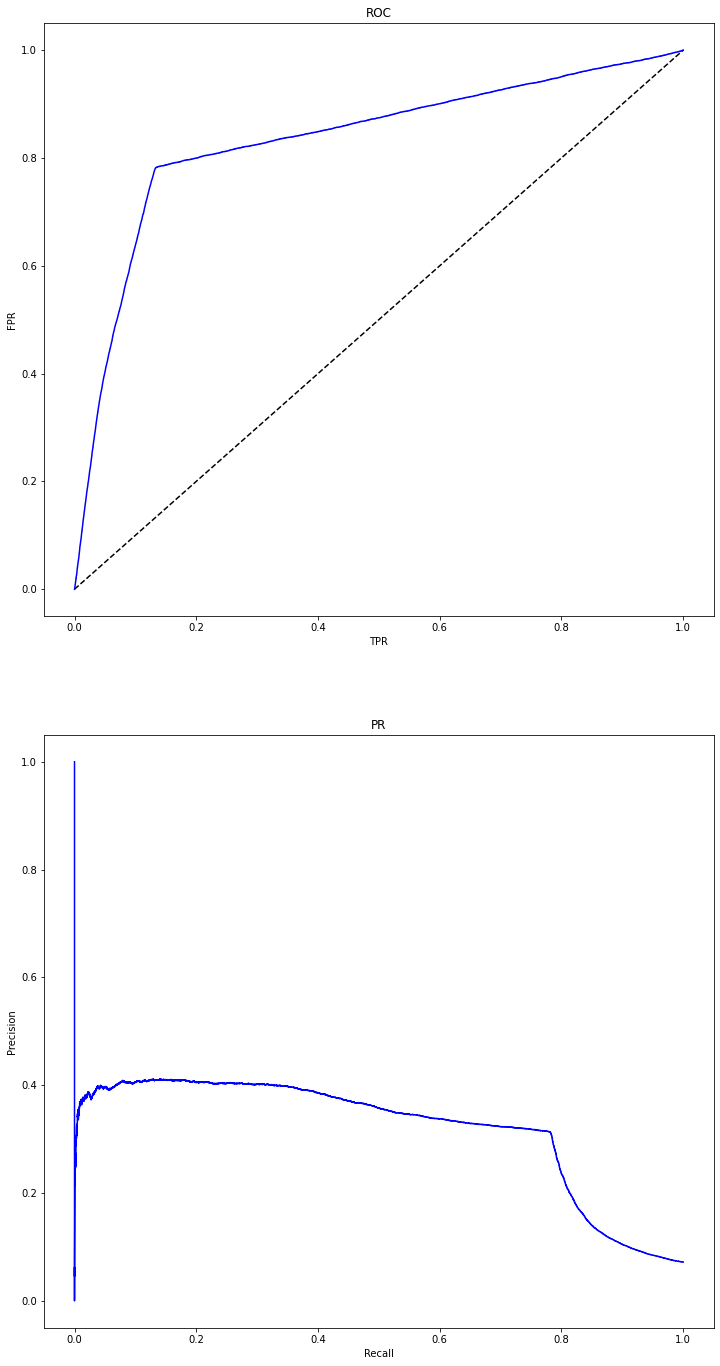

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_)
ax1.plot(fpr, tpr, label='Top_1', color='b')
ax2.plot(recall, precision, label='Top_1', color='b')
print("Top_1: AUC_PR = %.3f" % auc(recall, precision))
print("Top_1: AUC_ROC = %.3f" % auc(fpr, tpr))

